In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, kendalltau

results = np.load("/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac0_cog0.npz")
beta = results['beta_history']


df = pd.read_csv("/data01/bgutman/MRI_data/PPMI/data_ppmi_pd.csv")
df_K = pd.read_csv("/data01/bgutman/LEGACY/Skoltech/datasets/Connectomes/mean_NORM_con_22.csv")

## remove non-longitudinal observations
print("original size:", df.shape)
relevant_cols = [col for col in df.columns if col.startswith(('L_', 'R_')) and ('_thickavg' in col or '_thickavg_resid' in col)]
relevant_cols += ["MCATOT", "TD_score", "PIGD_score", "NSD_STAGE", "NHY"]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=relevant_cols)

print("after drop na", df.shape)
subj_counts = df['subj_id'].value_counts()
num_unique = (subj_counts == 1).sum()
print("one time subj_id:", num_unique)

longitudinal_ids = subj_counts[subj_counts > 1].index
df = df[df['subj_id'].isin(longitudinal_ids)].copy()
df = df.drop_duplicates(subset=["subj_id", "time"])
print("after drop dupes", df.shape)

X = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg') and not col.endswith('_thickavg_resid'))]]
X_resid = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg_resid'))]]

X = X.to_numpy()
X_resid = X_resid.to_numpy()

print("nans in X:", np.isnan(X).sum())
print("infs in X:", np.isinf(X).sum())

print("nans X_resid:", np.isnan(X_resid).sum())
print("infs X_resid:", np.isinf(X_resid).sum())

## connectivity matrix to numpy
K = df_K.drop(df_K.columns[0], axis=1).to_numpy()
np.fill_diagonal(K, 0)
print(K.shape, type(K))

# normalization
row_sums = K.sum(axis=1)
bin_row_sums = np.sum(K > 0, axis=1)
zeros = np.sum(row_sums == 0)
print("zeros: ", zeros)
median_row_sum = np.median(row_sums)
K = K / median_row_sum

t_max = 20
step = 0.001

print("X.size: ", X.shape, "X_resid.size: ", X_resid.shape)

ids = df["subj_id"].to_numpy()
dt = df["time"].to_numpy()/12 # convert to years
#cog = df["MCATOT"].values#,"TD_score","PIGD_score"]].values
cog = df[["MCATOT","TD_score","PIGD_score"]].to_numpy()

nsd_stage = df["NSD_STAGE"].to_numpy()
print(np.unique(nsd_stage))
for i, stage in enumerate(nsd_stage):
    if stage == '2b':
        nsd_stage[i] = '2'
    if stage == 'Not NSD':
        nsd_stage[i] = 0
        
nsd_stage = nsd_stage.astype('float')

nhy = df["NHY"].to_numpy()

pigd = df["PIGD_score"].to_numpy()
td_score = df["TD_score"].to_numpy()
mcatot = df["MCATOT"].to_numpy()

print("nans in cog:", np.isnan(cog).sum())
print("infs in cog:", np.isinf(cog).sum())


original size: (880, 250)
after drop na (836, 250)
one time subj_id: 214
after drop dupes (488, 250)
nans in X: 0
infs in X: 0
nans X_resid: 0
infs X_resid: 0
(68, 68) <class 'numpy.ndarray'>
zeros:  2
X.size:  (488, 68) X_resid.size:  (488, 68)
['2b' '3' '4' '5' '6' 'Not NSD']
nans in cog: 0
infs in cog: 0


(array([ 7., 17., 11., 17., 16., 15., 16., 16., 18., 13.]),
 array([-11.63757424,  -9.49411389,  -7.35065354,  -5.20719319,
         -3.06373285,  -0.9202725 ,   1.22318785,   3.3666482 ,
          5.51010855,   7.65356889,   9.79702924]),
 <BarContainer object of 10 artists>)

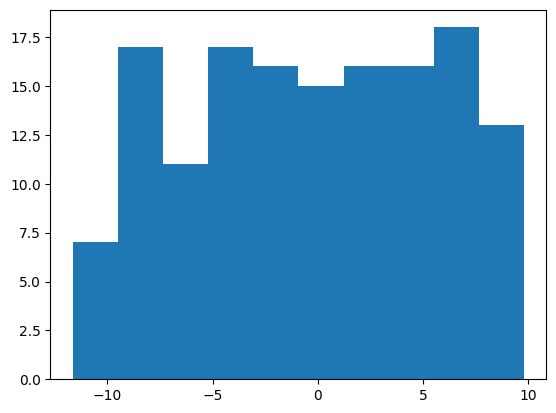

In [4]:
import matplotlib.pyplot as plt
plt.hist(beta[:,0] - beta[:,-1])

(array([15., 11., 14., 15., 12., 18., 15., 15., 17., 14.]),
 array([ 0.07660147,  2.06634288,  4.05608429,  6.04582569,  8.0355671 ,
        10.02530851, 12.01504991, 14.00479132, 15.99453273, 17.98427413,
        19.97401554]),
 <BarContainer object of 10 artists>)

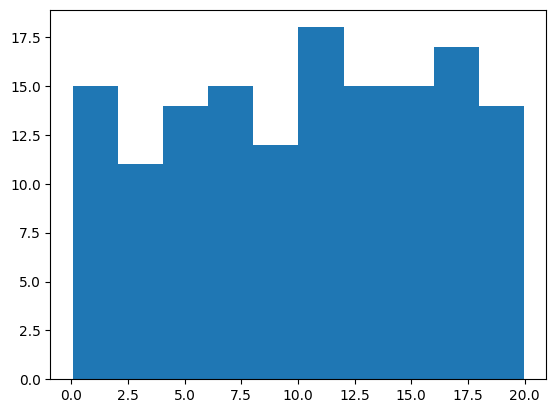

In [5]:
import matplotlib.pyplot as plt
plt.hist(beta[:,0])

(array([ 1., 11., 40., 29., 24., 18.,  7.,  8.,  6.,  2.]),
 array([ 8.98578234,  9.371876  ,  9.75796967, 10.14406333, 10.530157  ,
        10.91625066, 11.30234433, 11.68843799, 12.07453166, 12.46062533,
        12.84671899]),
 <BarContainer object of 10 artists>)

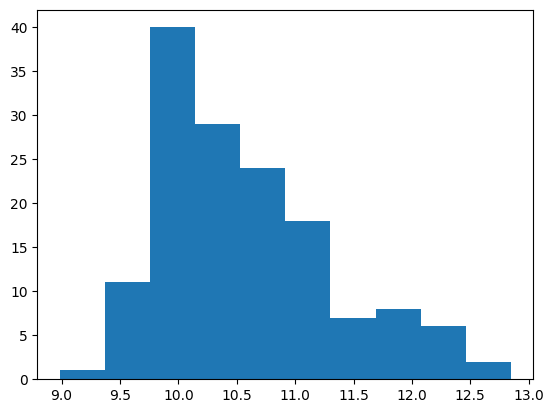

In [6]:
import matplotlib.pyplot as plt
plt.hist(beta[:,-1])

/tmp/ipykernel_21026/3802703820.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x="NSD_STAGE", y="beta", inner="box", palette="muted", linewidth=1)


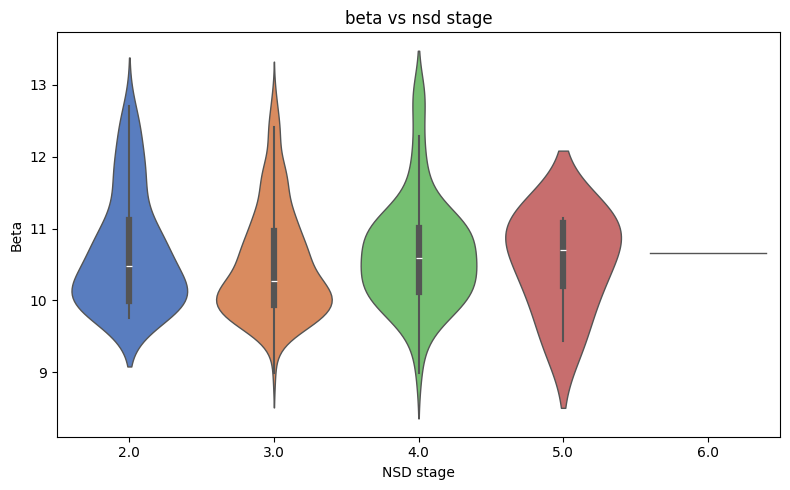

In [ ]:
unique_ids = pd.unique(ids)
final_beta = beta[:,-1]  # (num_unique_ids,)
id_to_beta = dict(zip(unique_ids, final_beta))
beta_full = np.array([id_to_beta[i] for i in ids])


df_plot = df.copy()
df_plot["beta"] = beta_full

# drop NaNs in NSD_STAGE
df_plot = df_plot.dropna(subset=["NSD_STAGE"])

df_plot["NSD_STAGE"] = df_plot["NSD_STAGE"].astype(float)

# plot
plt.figure(figsize=(8, 5))
sns.violinplot(data=df_plot, x="NSD_STAGE", y="beta", inner="box", palette="muted", linewidth=1)
plt.title("beta vs nsd stage")
plt.xlabel("NSD stage")
plt.ylabel("Beta")
plt.tight_layout()
plt.show()

In [8]:
beta_full.shape

(488,)

In [9]:
nhy.shape

(488,)

/tmp/ipykernel_21026/3008424600.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=beta_full, x=nhy, palette="muted")


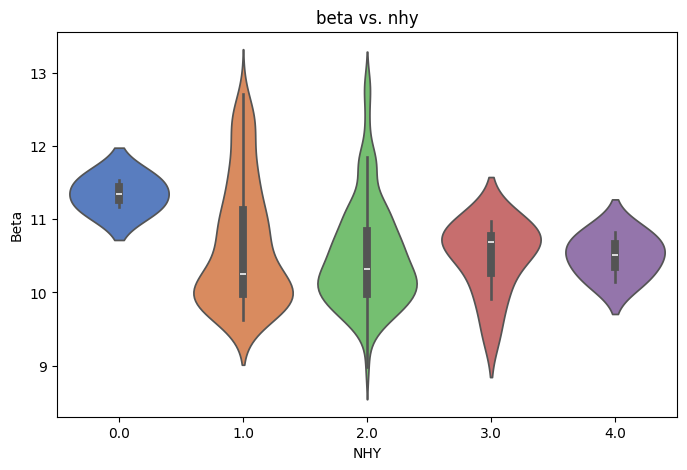

/tmp/ipykernel_21026/3008424600.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=beta_full, x=nsd_stage, palette="muted")


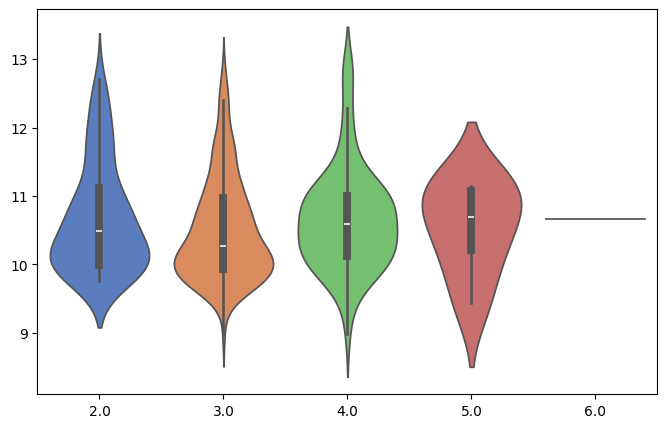

In [10]:
plt.figure(figsize=(8, 5))
sns.violinplot(y=beta_full, x=nhy, palette="muted")
plt.title("beta vs. nhy")
plt.xlabel("NHY")
plt.ylabel("Beta")
plt.show()

plt.figure(figsize=(8, 5))
sns.violinplot(y=beta_full, x=nsd_stage, palette="muted")
plt.show()

In [26]:
print("NSD spearman:")
print(spearmanr(beta_full, nsd_stage))
print("NHY spearman:")
print(spearmanr(beta_full, nhy))
print("MCATOT")
print(spearmanr(beta_full, mcatot))
print("TD score")
print(spearmanr(beta_full, td_score))
print("PIGD score")
print(spearmanr(beta_full, pigd))

NSD spearman:
SignificanceResult(statistic=0.044519499933380884, pvalue=0.32637952749420096)
NHY spearman:
SignificanceResult(statistic=-0.03859414486302026, pvalue=0.39493431265143375)
MCATOT
SignificanceResult(statistic=0.06264880174538576, pvalue=0.16704365129805585)
TD score
SignificanceResult(statistic=-0.015246529855580239, pvalue=0.7368990390139307)
PIGD score
SignificanceResult(statistic=0.04976824259406381, pvalue=0.2725203117398646)
